In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from itertools import product
from difflib import SequenceMatcher

import re
import json
from pathlib import Path

import pandas as pd
import numpy as np

In [3]:
data_dir = Path("../data/tpcc/")

In [4]:
data_dict = {}
json_paths = data_dir.glob("*.json")
for path in json_paths:
    with open(path, "r") as f:
        metric = path.name[:-24]
        results = json.load(f)["results"]
        metric_set = set()
        for src_data in results:
            for data in src_data["data"]:
                metric_set.add(data["metric"])
        for src_data in results:
            if src_data["source"][:10] != "summarizer":
                for data in src_data["data"]:
                    # jsonのキーは順番保証されていないので念の為ソート
                    tags = [data["tags"][key] for key in sorted(data["tags"].keys()) if key != "origin"]
                    key_name = metric
                    # metricフィールドが全て同じならキー名に含めない
                    if len(metric_set) > 1:
                        # metricフィールドの冗長な名前を簡潔化
                        metric_attr = re.findall('^.*\.(.*)$', data['metric'])[0]
                        key_name += f"-{metric_attr}"
                    if len(tags) > 0:
                        key_name += f"-{'-'.join(tags)}"
                    data_dict[key_name] = data["NumericType"]
df = pd.DataFrame(data_dict, dtype="float32")
df.dropna(inplace=True)
# query数が0近くから急激に上昇した直後 or 急激に0近くまで下降した直前のデータを取り除く
query_nums = df.filter(like="query-").sum(axis=1)
rm_indices = set(query_nums[query_nums < 500].index.to_list())
rm_indices = rm_indices | {idx + 1 for idx in rm_indices if idx < len(df)} | {idx - 1 for idx in rm_indices if idx > 1} | {1, len(df)}
df.drop(rm_indices, axis=0, inplace=True)

In [5]:
df.columns

Index(['cpu-usage_irq', 'cpu-usage_iowait', 'cpu-usage_nice',
       'cpu-usage_guest_nice', 'cpu-usage_steal', 'cpu-usage_user',
       'cpu-usage_guest', 'cpu-usage_system', 'cpu-usage_softirq',
       'handler-discover', 'handler-savepoint_rollback',
       'handler-external_lock', 'handler-commit', 'handler-read_next',
       'handler-delete', 'handler-read_first', 'handler-read_prev',
       'handler-read_last', 'handler-read_rnd_next', 'handler-read_key',
       'handler-mrr_init', 'handler-update', 'handler-write',
       'handler-savepoint', 'handler-rollback', 'handler-read_rnd',
       'handler-prepare', 'query-alter_table', 'query-select', 'query-replace',
       'query-create_table', 'query-delete', 'query-update',
       'query-drop_index', 'query-drop_table', 'query-commit', 'query-insert',
       'swap-in', 'swap-out',
       'threads_connected-mysql_global_status_threads_running',
       'threads_connected-mysql_global_status_threads_connected', 'tmp_tables',
       'av

In [6]:
apj_metric_set = {'avg_cpu-usage_idle', 'avg_cpu-usage_softirq', 'avg_cpu-usage_system',
       'avg_cpu-usage_iowait', 'avg_cpu-usage_user', 'avg_cpu-usage_steal',
       'avg_cpu-usage_nice', 'avg_disk_busy-vdb', 'avg_disk_busy-vda2',
       'avg_disk_iops-writes-vda2', 'avg_disk_iops-writes-vdb',
       'avg_disk_iops-reads-vda2', 'avg_disk_iops-reads-vdb',
       'avg_handler-read_key', 'avg_handler-update', 'avg_handler-read_first',
       'avg_handler-rollback', 'avg_handler-write',
       'avg_handler-read_rnd_next', 'avg_handler-read_last',
       'avg_handler-read_next', 'avg_handler-external_lock',
       'avg_handler-read_rnd', 'avg_handler-commit', 'avg_handler-delete',
       'avg_handler-read_prev', 'avg_handler-prepare',
       'avg_innodb_rows_read-read', 'avg_innodb_rows_updated-inserted',
       'avg_innodb_rows_updated-deleted', 'avg_innodb_rows_updated-updated',
       'avg_memory_usage', 'avg_network_send_received-bytes_sent-eth0',
       'avg_network_send_received-bytes_recv-eth0', 'avg_pages_swap_in_out-in',
       'avg_pages_swap_in_out-out', 'avg_query_commands-select',
       'avg_query_commands-delete', 'avg_query_commands-update',
       'avg_query_commands-insert', 'avg_query_commands-replace',
       'avg_slow_query',
       'avg_threads_connected-mysql_global_status_threads_connected',
       'avg_threads_connected-mysql_global_status_threads_running',
       'disk_usage_(data_volume)___binlog_file_total_size-used-vdb',
       'disk_usage_(percent)-vdb', 'disk_usage_(percent)-vda2'
}

In [13]:
tpcc2apj = {key: None for key in df.keys()}
similarity_dict = {key: 0 for key in df.keys()}
for pair in product(df.keys(), apj_metric_set):
    tpcc, apj = pair
    avg_tpcc = "avg_" + tpcc if tpcc[:3] != "avg" else tpcc
    avg_tpcc = avg_tpcc.replace("%", "percent")
    m1 = SequenceMatcher(None, avg_tpcc, apj).ratio()
    m2 = SequenceMatcher(None, apj, avg_tpcc).ratio()
    similarity = max(m1, m2)
    if similarity > similarity_dict[tpcc]:
        tpcc2apj[tpcc] = apj
        similarity_dict[tpcc] = similarity
for key in tpcc2apj.keys():
    if similarity_dict[key] != 1.0:
        print(key, '/', tpcc2apj[key], '/', similarity_dict[key])

cpu-usage_irq / avg_cpu-usage_softirq / 0.8947368421052632
cpu-usage_guest_nice / avg_cpu-usage_nice / 0.8571428571428571
cpu-usage_guest / avg_cpu-usage_user / 0.8648648648648649
handler-discover / avg_handler-write / 0.7567567567567568
handler-savepoint_rollback / avg_handler-rollback / 0.8
handler-mrr_init / avg_handler-write / 0.8108108108108109
handler-savepoint / avg_handler-commit / 0.7692307692307693
query-alter_table / avg_query_commands-delete / 0.5652173913043478
query-select / avg_query_commands-select / 0.7804878048780488
query-replace / avg_query_commands-replace / 0.7906976744186046
query-create_table / avg_query_commands-replace / 0.5833333333333334
query-delete / avg_query_commands-delete / 0.7804878048780488
query-update / avg_query_commands-update / 0.7804878048780488
query-drop_index / avg_handler-read_next / 0.5853658536585366
query-drop_table / avg_query_commands-replace / 0.6086956521739131
query-commit / avg_handler-commit / 0.7647058823529411
query-insert / avg

In [ ]:
drop_pseudo_cols = ['cpu-usage_irq',
    'cpu-usage_guest_nice',
    'cpu-usage_guest',
    'handler-discover',
    'handler-savepoint_rollback',
    'handler-mrr_init',
    'handler-savepoint',
    'query-alter_table',
    'query-create_table',
    'query-drop_index',
    'query-drop_table',
    'query-commit',
    'tmp_tables',
    'avg_lock_wait_time',
    'avg_sort-merge_passes',
    'buffer_hit_ratio%',
    'innodb_io-mysql_global_status_innodb_data_read',
    'innodb_io-mysql_global_status_innodb_data_written',
    'query_response_time'
]

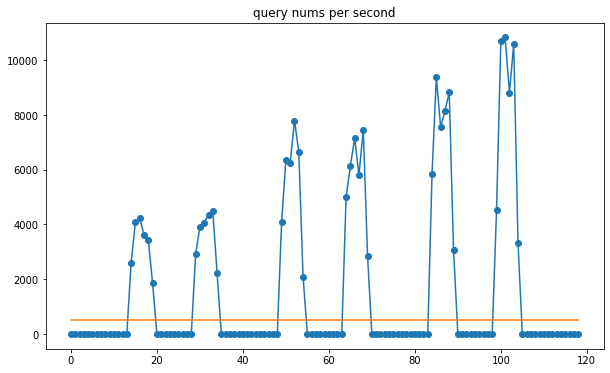

In [20]:
metric = "query nums per second"
plt.figure(figsize=(10, 6))
plt.plot(range(len(query_nums)), query_nums, 'o-')
plt.plot(range(len(query_nums)), [500] * len(query_nums))
plt.title(metric)
plt.show()

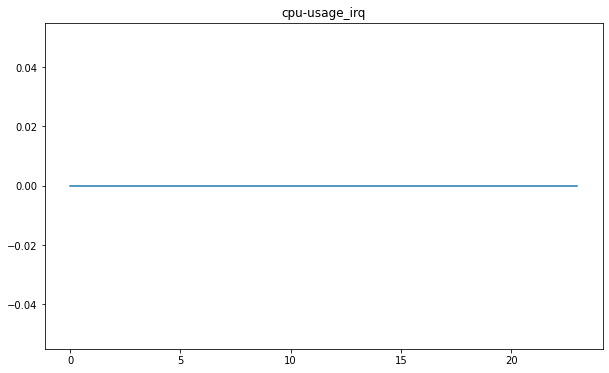

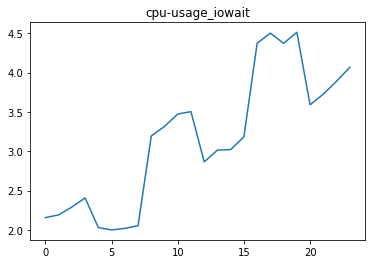

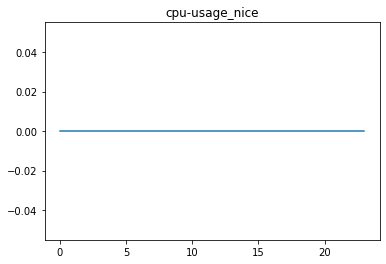

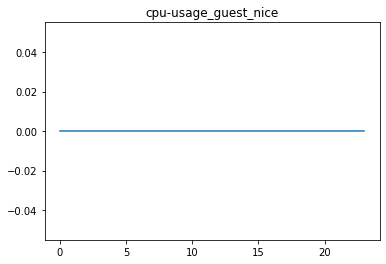

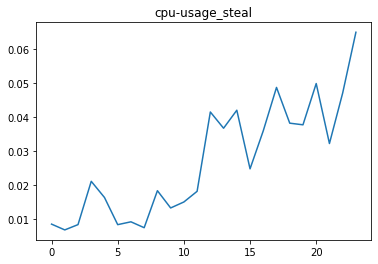

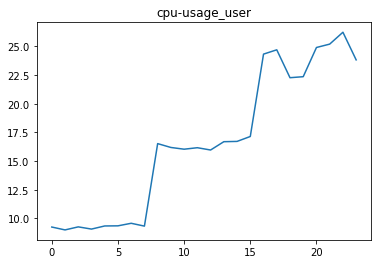

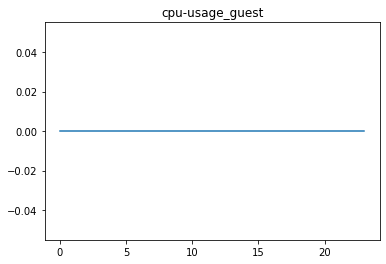

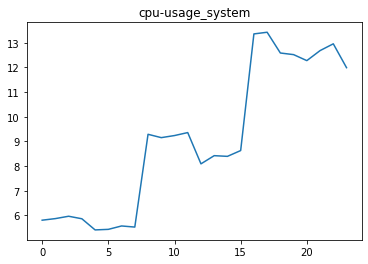

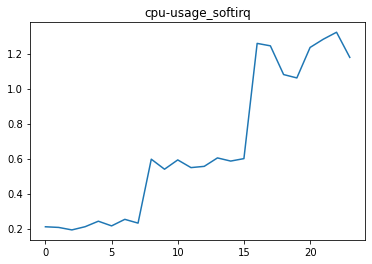

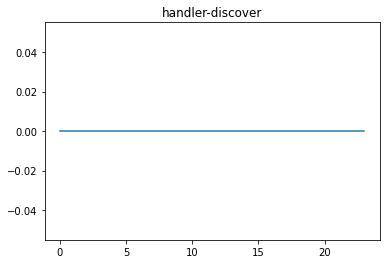

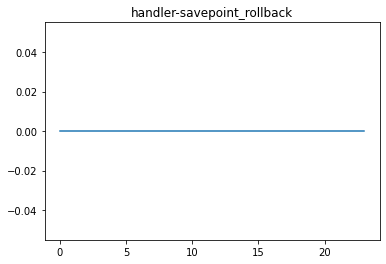

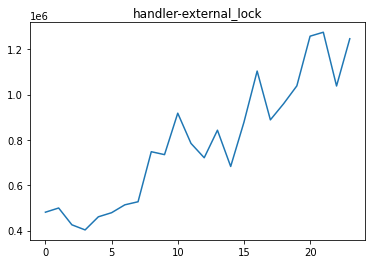

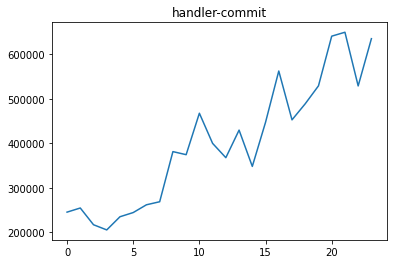

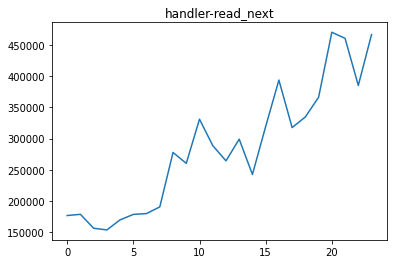

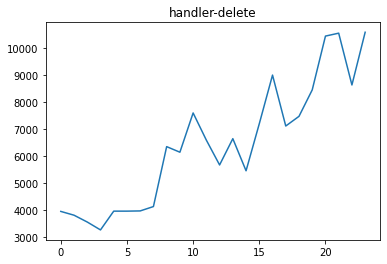

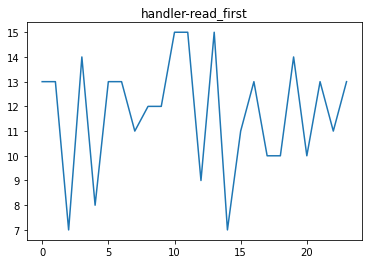

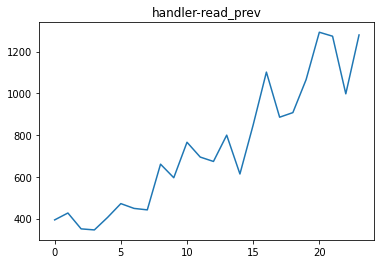

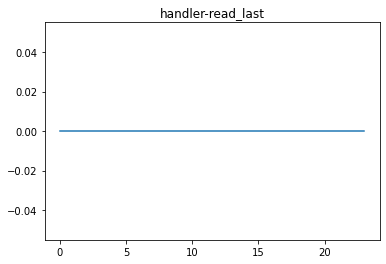

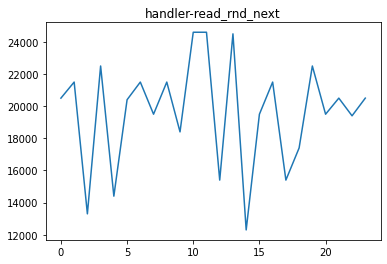

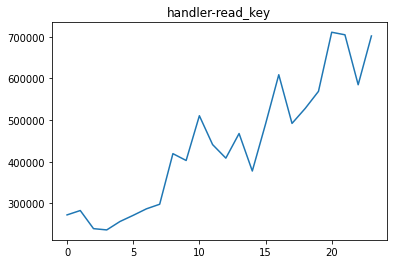

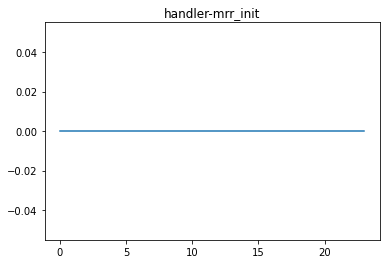

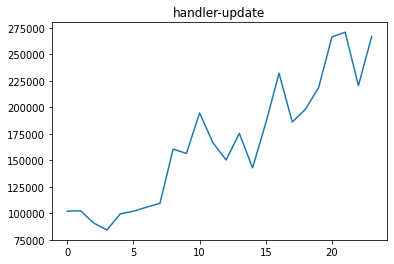

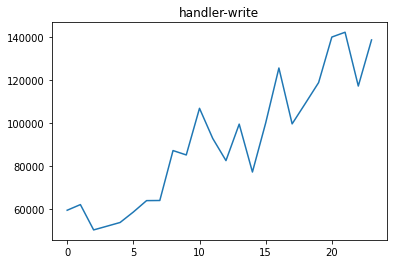

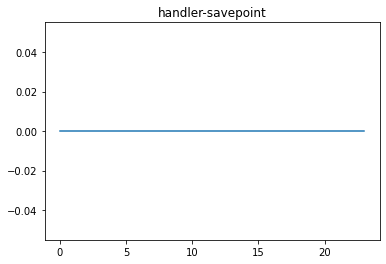

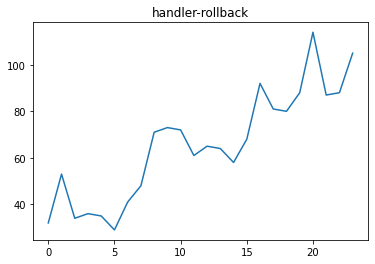

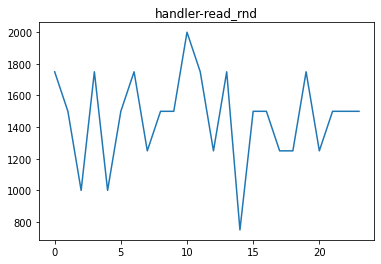

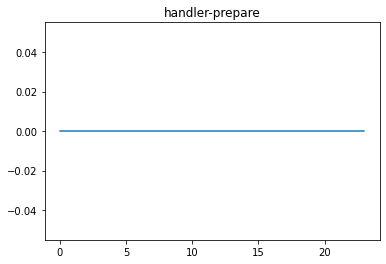

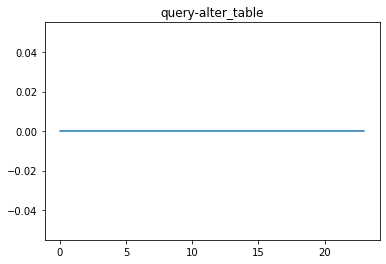

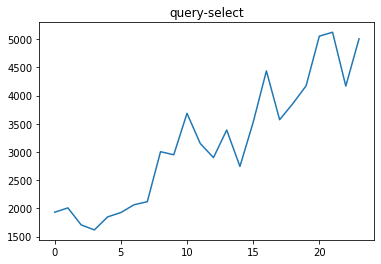

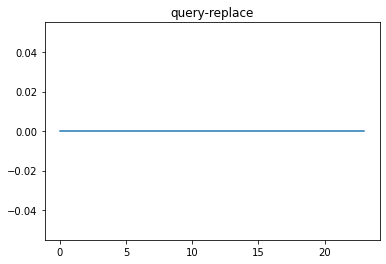

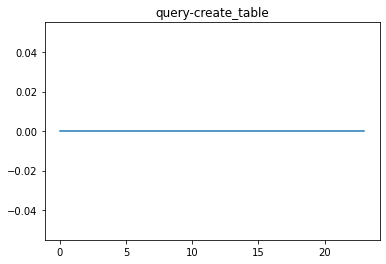

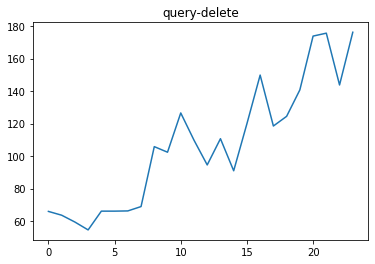

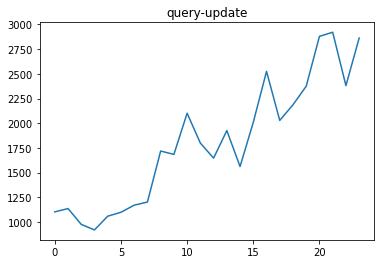

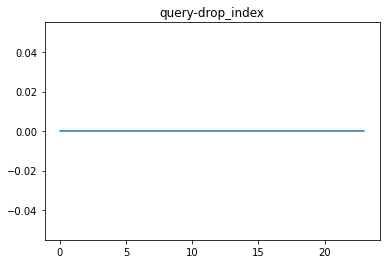

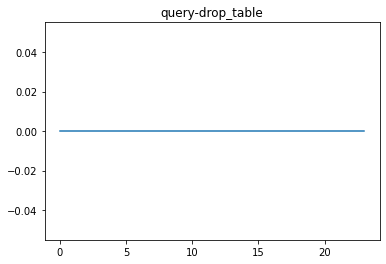

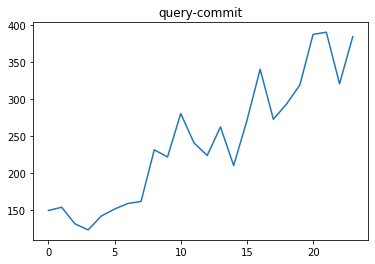

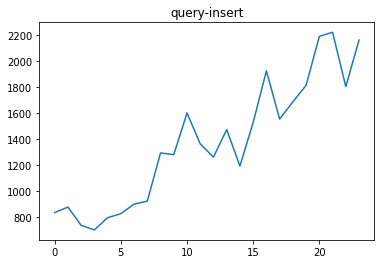

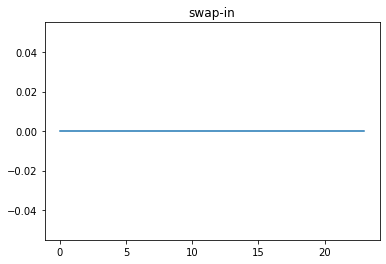

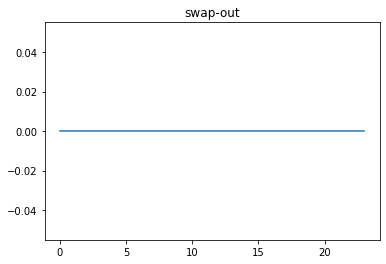

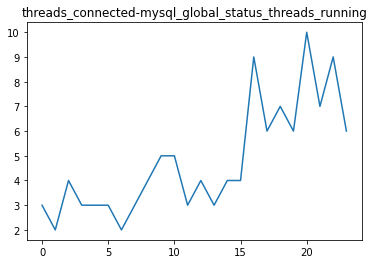

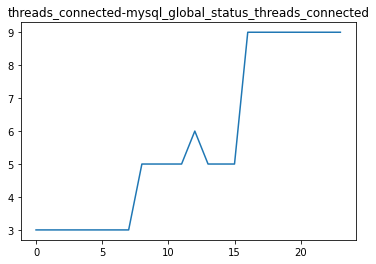

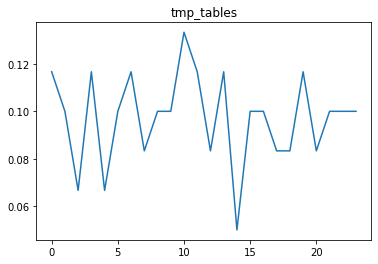

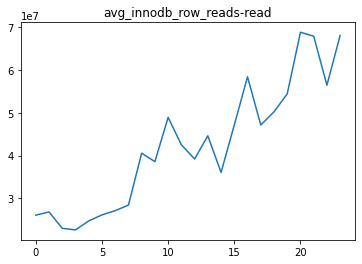

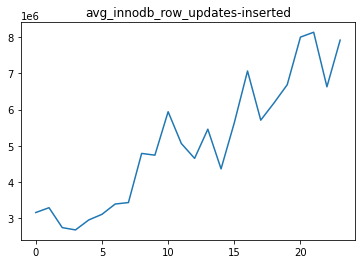

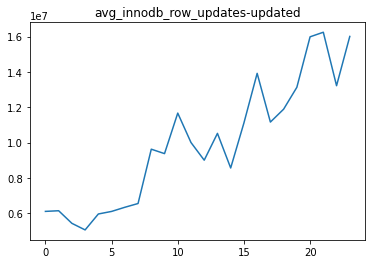

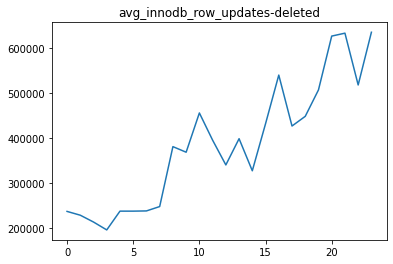

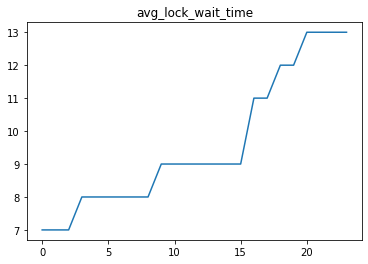

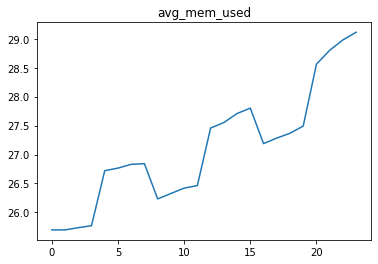

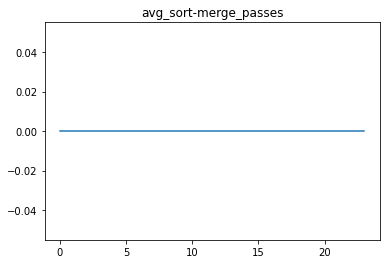

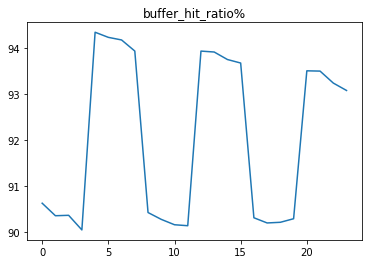

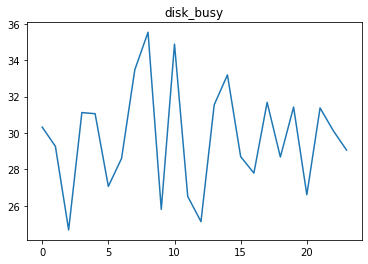

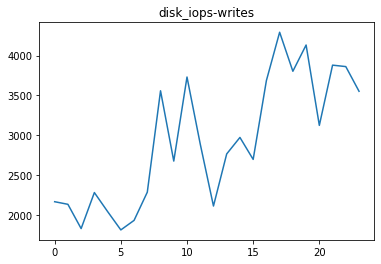

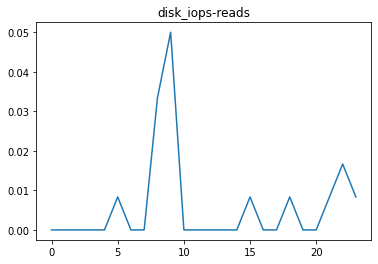

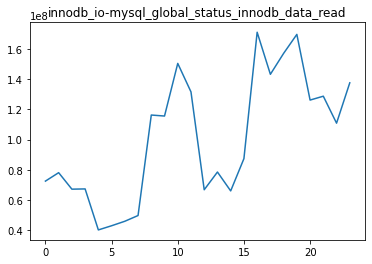

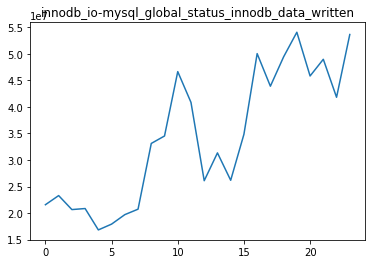

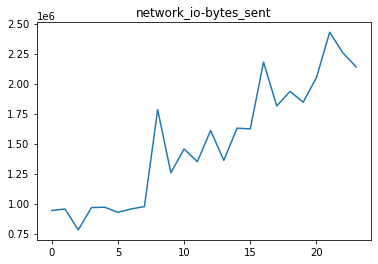

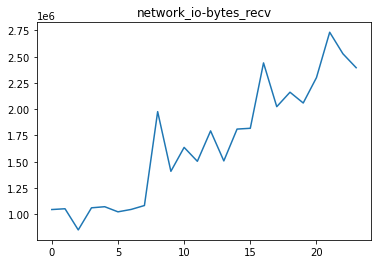

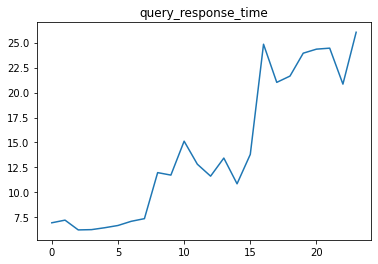

In [19]:
plt.figure(figsize=(10, 6))
for metric in df.columns:
    plt.plot(range(len(df)), df[metric])
    plt.title(metric)
    plt.show()

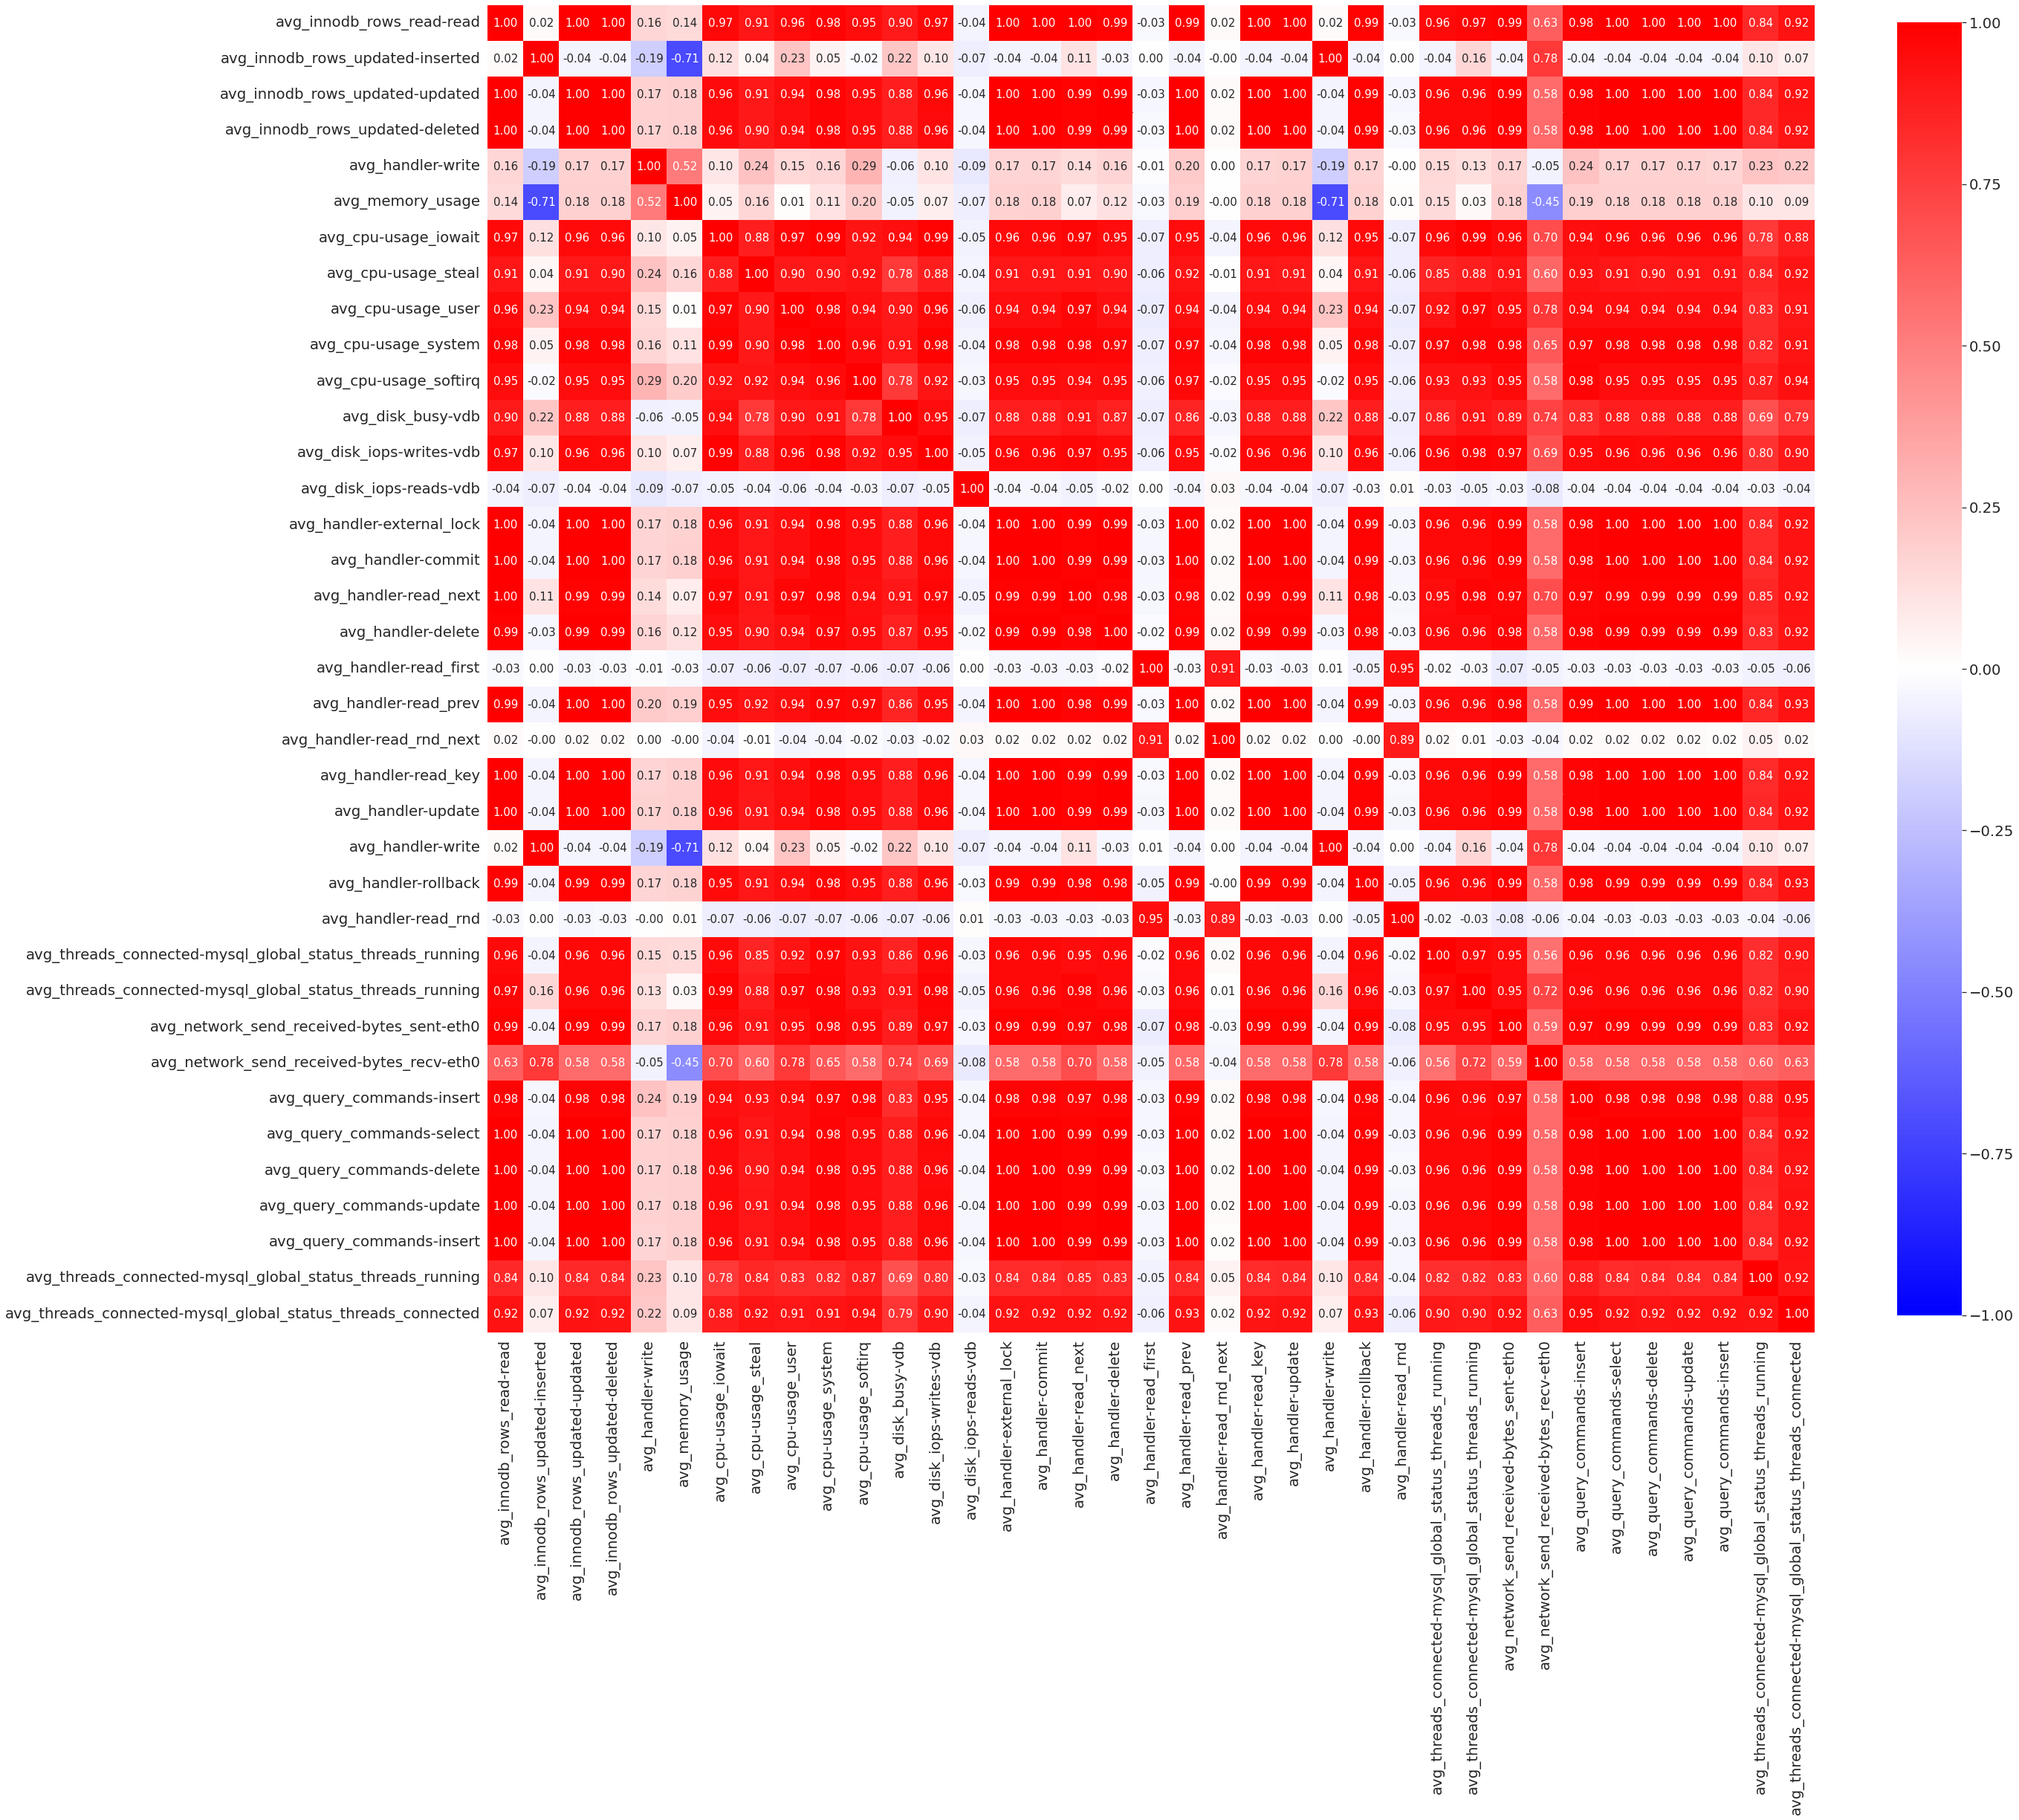

In [9]:
# 値が一定のメトリックを除いて分析
df_tmp = df.loc[:, df.nunique() != 1]

sns.set(font_scale=1.8)
plt.figure(figsize=(40, 40))
sns.heatmap(df_tmp.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 15}, cbar_kws={"shrink": 0.8}, fmt=".2f")
plt.show()

### 閾値を徐々に下げて削除していく
これにより相関が非常に高いものを優先的に削除できる

['avg_innodb_rows_read-read',
 'avg_cpu-usage_system',
 'avg_threads_connected-mysql_global_status_threads_running',
 'avg_innodb_rows_updated-updated',
 'avg_innodb_rows_updated-deleted',
 'avg_disk_iops-writes-vdb',
 'avg_handler-external_lock',
 'avg_handler-commit',
 'avg_handler-read_next',
 'avg_handler-read_key',
 'avg_handler-update',
 'avg_handler-rollback',
 'avg_network_send_received-bytes_sent-eth0',
 'avg_handler-read_prev',
 'avg_cpu-usage_iowait',
 'avg_cpu-usage_softirq',
 'avg_handler-delete',
 'avg_innodb_rows_updated-inserted',
 'avg_cpu-usage_user',
 'avg_cpu-usage_steal',
 'avg_threads_connected-mysql_global_status_threads_connected',
 'avg_handler-read_first',
 'avg_disk_busy-vdb',
 'avg_handler-read_rnd_next',
 'avg_handler-write']

the number of deleted metrics: 25


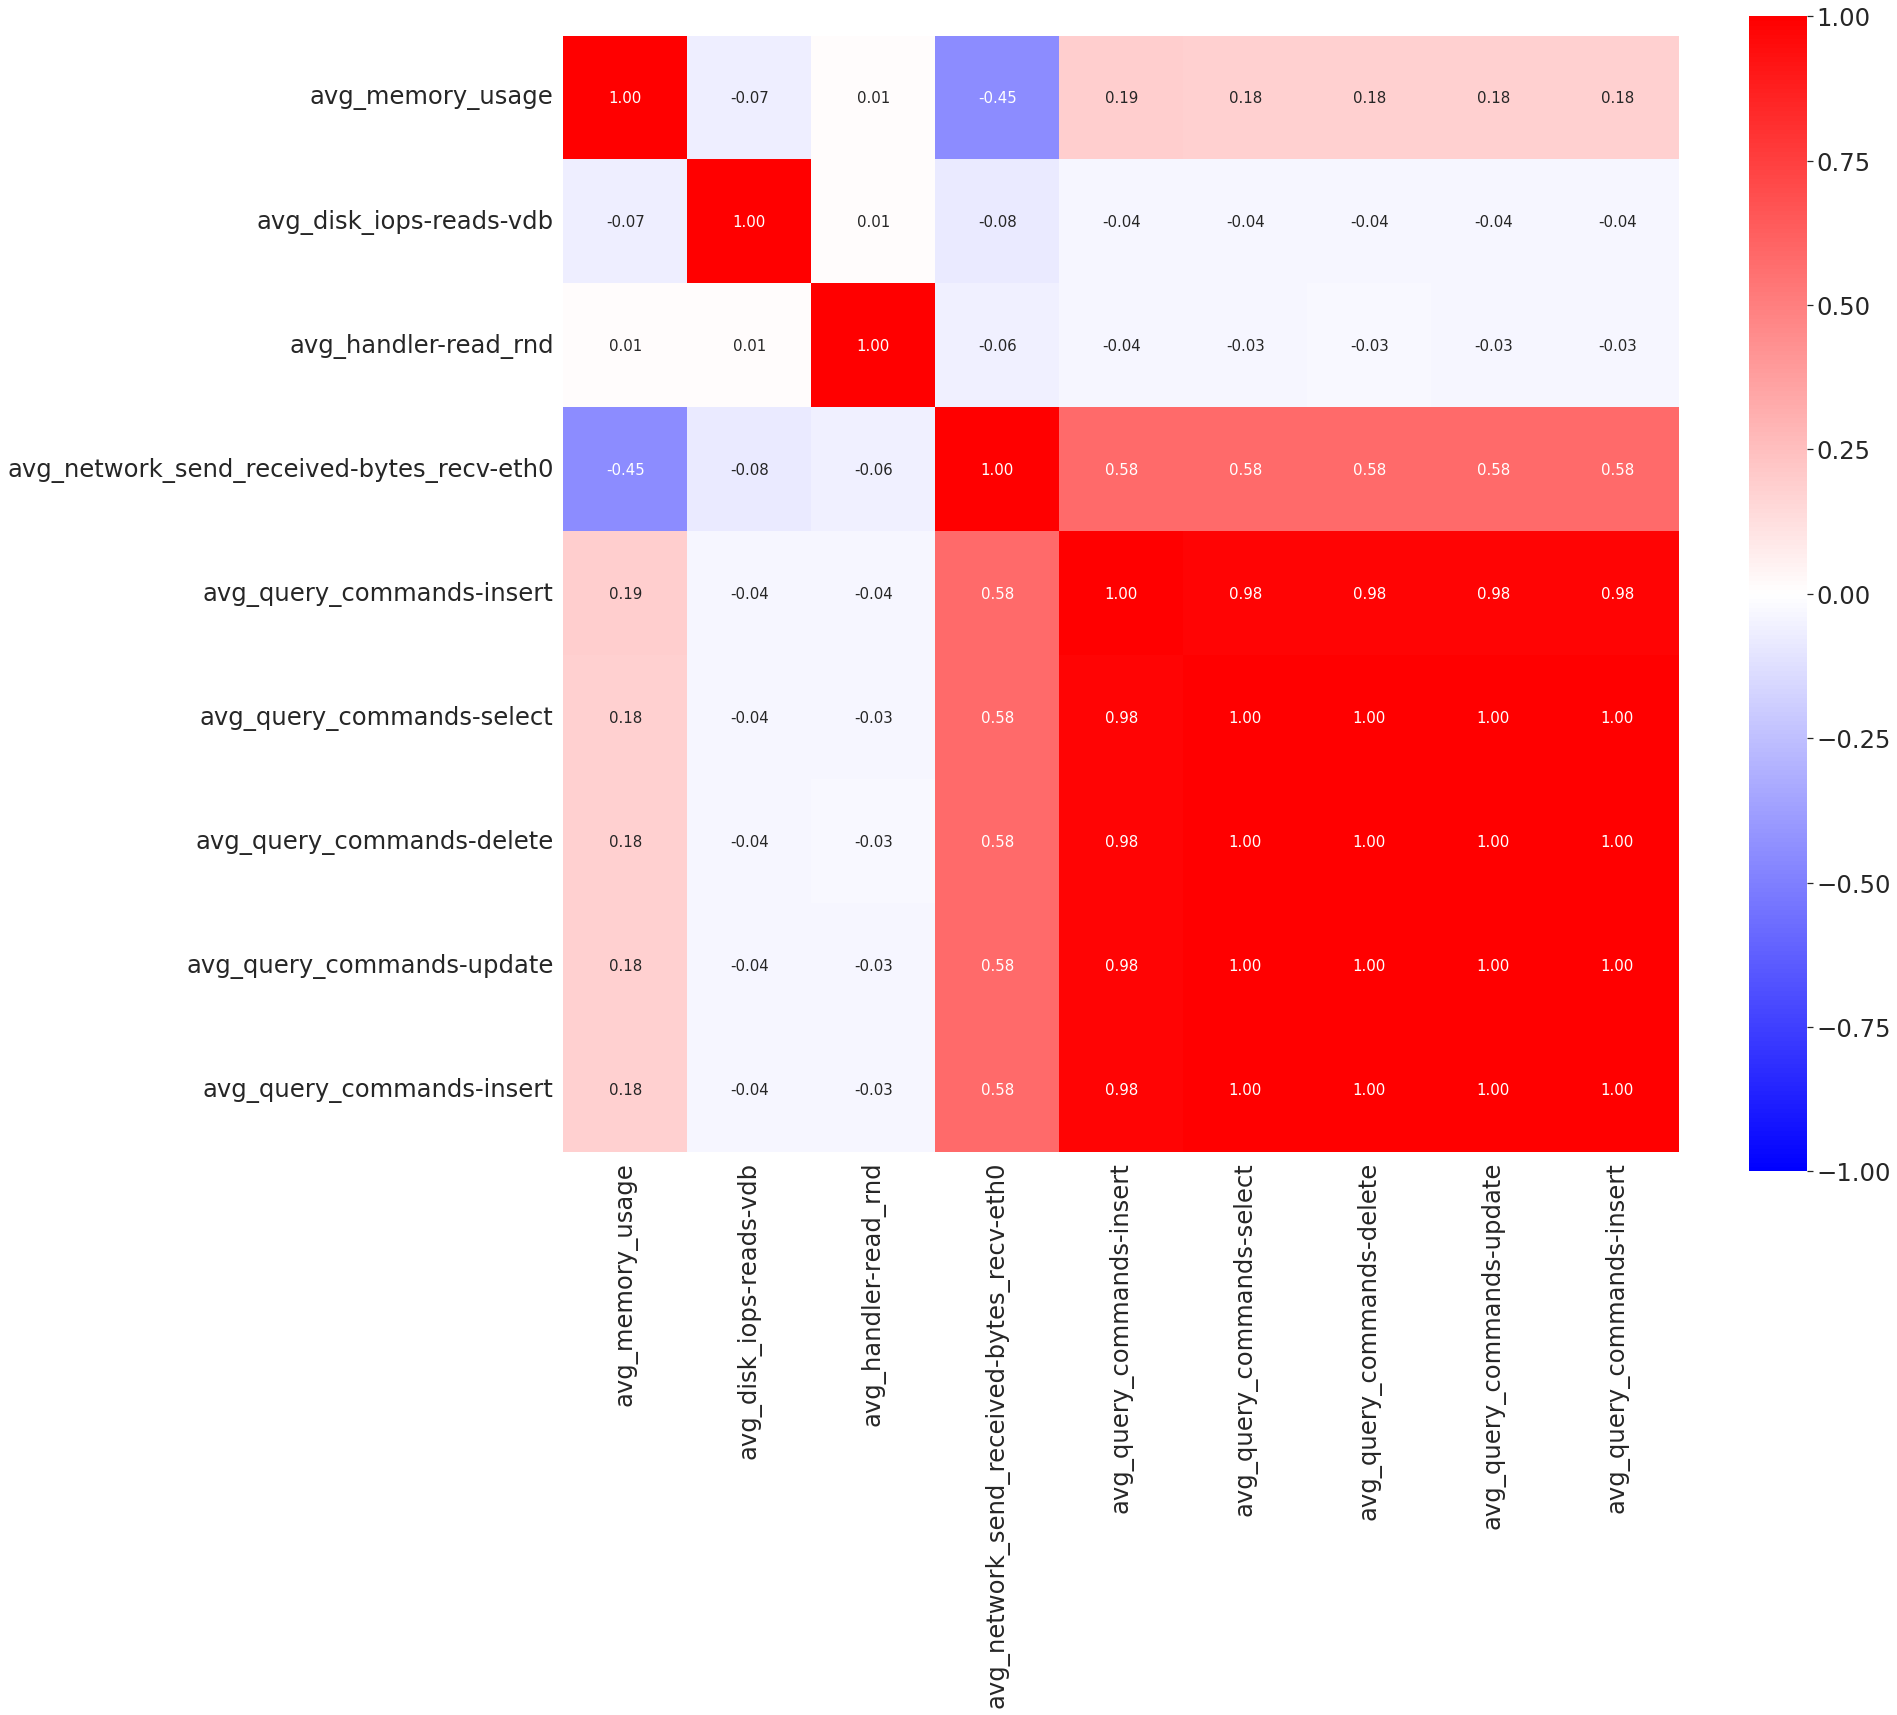

In [10]:
sns.set(font_scale=2.2)
df_tmp = df.loc[:, df.nunique() != 1]
df_selected = df_tmp.copy()
del_lim = 25
del_num = 0
ths = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
del_metrics_all = []

for th in ths:
    df_corr = df_selected.corr()
    corr_mat = df_corr.to_numpy()
    cols = df_corr.columns

    # 相関が th 以上 or -th 以下のメトリックを取り出す
    high_corrs_dict = {k: set() for k in cols}
    for i, j in zip(*np.where((corr_mat >= th) | (corr_mat <= -th))):
        if i < j:
            # queryはworkloadを最もよく表しているので，消さないようにする
            if cols[i][:9] != "avg_query":
                high_corrs_dict[cols[i]].add(cols[j])
            if cols[j][:9] != "avg_query":
                high_corrs_dict[cols[j]].add(cols[i])
    del_metrics = []
    while del_num < del_lim:
        # 相関が高いメトリック間の関係数をメトリック別に列挙
        # （メトリックごとの関係数を相関係数の和で代用してもいい）
        del_metric = max(high_corrs_dict.items(), key=lambda item: len(item[1]))[0]
        if len(high_corrs_dict[del_metric]) == 0:
            break
        # keyを削除
        high_corrs_dict.pop(del_metric, None)
        # value(=set)の要素を削除
        for k, v_set in high_corrs_dict.items():
            if del_metric in v_set:
                v_set.discard(del_metric)
        del_metrics.append(del_metric)
        del_num += 1
    del_metrics_all += del_metrics
    df_selected.drop(del_metrics, axis=1, inplace=True)
pprint(del_metrics_all)
print(f"\nthe number of deleted metrics: {del_num}")
plt.figure(figsize=(25, 25))
sns.heatmap(df_selected.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 15}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()